# Advanced Analytics
This notebook contains advanced analytics including customer segmentation and churn prediction.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_processed_data():
    # Load processed data
    sales_df = pd.read_csv('../data/processed/processed_sales.csv')
    customers_df = pd.read_csv('../data/processed/processed_customers.csv')
    products_df = pd.read_csv('../data/processed/processed_products.csv')
    rfm_df = pd.read_csv('../data/processed/customer_rfm.csv')
    
    return sales_df, customers_df, products_df, rfm_df

In [3]:
def perform_customer_segmentation(rfm_df):
    # Select RFM metrics for clustering
    rfm_data = rfm_df[['Recency', 'Frequency', 'Monetary']]
    
    # Scale the data
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_data)
    
    # Determine optimal number of clusters using Elbow method
    sse = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(rfm_scaled)
        sse[k] = kmeans.inertia_
    
    # Plot Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
    # Apply K-means clustering (assuming 4 clusters based on elbow method)
    kmeans = KMeans(n_clusters=4, random_state=42)
    rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)
    
    # Analyze segments
    segment_analysis = rfm_df.groupby('Segment').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Count'})
    
    return rfm_df, segment_analysis

In [4]:
def predict_churn(rfm_df, days_threshold=90):
    # Create churn label (1 if customer hasn't purchased in 'days_threshold' days)
    rfm_df['Churn'] = (rfm_df['Recency'] > days_threshold).astype(int)
    
    # Prepare features and target
    X = rfm_df[['Recency', 'Frequency', 'Monetary']]
    y = rfm_df['Churn']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate model
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return model, feature_importance

In [5]:
def main():
    # Load processed data
    sales_df, customers_df, products_df, rfm_df = load_processed_data()
    
    # Perform customer segmentation
    print("Performing customer segmentation...")
    rfm_df, segment_analysis = perform_customer_segmentation(rfm_df)
    print("\nSegment Analysis:")
    print(segment_analysis)
    
    # Predict churn
    print("\nTraining churn prediction model...")
    model, feature_importance = predict_churn(rfm_df)
    print("\nFeature Importance for Churn Prediction:")
    print(feature_importance)
    
    # Save results
    rfm_df.to_csv('../data/processed/customer_segments.csv', index=False)

Performing customer segmentation...


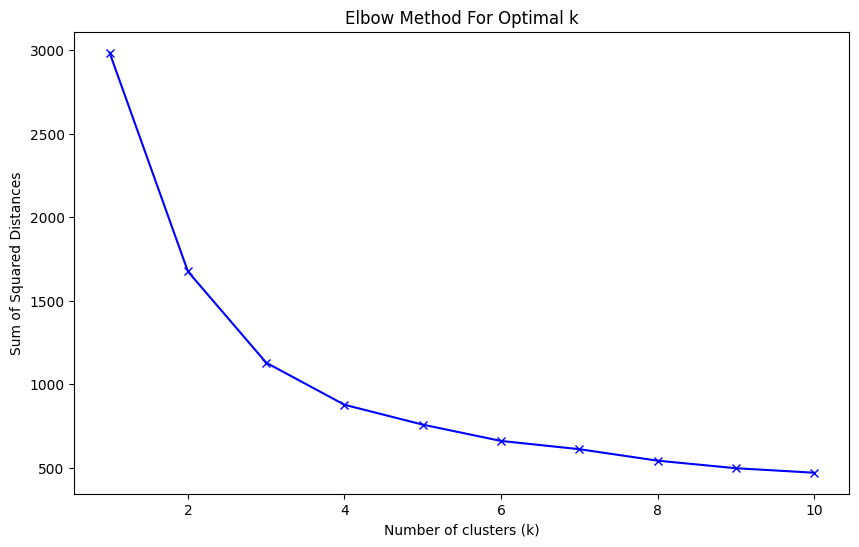


Segment Analysis:
            Recency  Frequency      Monetary  Count
Segment                                            
0        372.779006   3.038674   3150.864420    181
1         95.689266   5.793785   6374.832797    354
2        102.663300   3.444444   3179.353064    297
3         83.834356   8.441718  10299.722270    163

Training churn prediction model...


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       123
           1       1.00      1.00      1.00       176

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299


Feature Importance for Churn Prediction:
     Feature  Importance
0    Recency    0.907937
2   Monetary    0.052931
1  Frequency    0.039133


In [6]:
if __name__ == "__main__":
    main()